In [1]:
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import numpy as np
import sys
%matplotlib inline

In [2]:
def time_in_seconds(val):
    if "-" in val:
        fields = val.split("-")
        sec=0.0
        for i in fields:
            if "s" in i: sec += float(i.strip("s"))
            if "m" in i: sec += 60 * float(i.strip("m"))
            if "h" in i: sec += 3600 * float(i.strip("h"))
        return sec
    else:
        return float(val.strip("s"))

In [3]:
def parse_report(file_name):
    buffer = []
    resources_dict = {
        "MPI Cores": "mpi", "Threads per core": "thrs", "Threads total": "thr_tot", 
        "Nodes Computing": "nodes", "Nodes IO": "nodes_io", "MPI tasks / GPU": "mpi/gpu",
    }
    resources = {}
    timing = {}
    log = False
    with open(file_name, 'r') as report:
        for line in report:
            if line == "\n": log = False
            if log: 
                buffer.append(line.strip())
            else:
                for key, val in resources_dict.items():
                    if key in line: resources[val] = int(line.strip().split(":")[1])
                if "Time-Profile" in line:
                    timing["Time-Profile"] = time_in_seconds(line.strip().split(":")[1])

            if "Clock:" in line: log = True

    for line in buffer:
        fields = line.split(":")
        timing[fields[0].strip()] = time_in_seconds(fields[1].strip().split()[0])
    return resources, timing

In [4]:
def build_dataframe(x_axis='mpi', factor=1, rename_cols={}):
    r_files = glob("r-*")

    data = {}
    for report in r_files:
        resources, timing = parse_report(report)
        for key, val in resources.items():
            if key in data:
                data[key].append(val)
            else:
                data[key] = [val,]
        for key, val in timing.items():
            if key in data:
                data[key].append(val)
            else:
                data[key] = [val,]
    
    scaling = pd.DataFrame(data)
    if rename_cols: 
        scaling.rename(columns=rename_cols, inplace=True)
    else:
        scaling.rename(columns={'Xo (procedure)': 'Xo', 'X (procedure)': 'X'}, inplace=True)
    scaling.sort_values(by=[x_axis], inplace=True)
    if 'mpi/gpu' in scaling: scaling['gpu'] = pd.Series(scaling['mpi'] / scaling['mpi/gpu'], dtype=np.int64)
    scaling['ideal'] = scaling[x_axis] / factor
    scaling['speedup'] = scaling[scaling[x_axis]>=factor]['Time-Profile'].max() / scaling['Time-Profile']
    scaling['efficiency'] = scaling.speedup / scaling.ideal * 100
    scaling['Self energy'] = scaling['HF'] + scaling['GW(ppa)']
    scaling['Other'] = scaling['Time-Profile'] - scaling['Dipoles'] - scaling['Xo'] - scaling['X'] - scaling['Self energy']
    scaling['node_h'] = scaling['nodes'] * scaling['Time-Profile'] / 3600
    return scaling

In [11]:
def build_scaling_plot(scaling, pile, colors, x_axis='mpi', x_label='MPI tasks', bar_width=1,
                       title=None, legend_loc=None, label=None, label_pos=None, efficiency=True, 
                       file_name='scaling.png', y_lim=None):
    if len(pile) != len(colors):
        sys.stderr.write("Error: the number of elements of pile and colors lists have to be the same.")
        return
    fig, ax1 = plt.subplots(figsize=(10, 7))

    bottom = pd.Series(dtype='float64')
    for key, color in zip(pile, colors):
        if bottom.empty:
            ax1.bar(scaling[x_axis], scaling[key], width=bar_width, color=color, label=key)
            bottom = scaling[key].copy()
        else:
            ax1.bar(scaling[x_axis], scaling[key], width=bar_width, color=color, label=key, bottom=bottom)
            bottom += scaling[key]

    ax1.set_xlabel(x_label,fontsize=20)
    ax1.set_ylabel('Time (sec)',fontsize=20)
    ax1.legend()
    if y_lim: ax1.set_ylim(y_lim)
    if legend_loc: ax1.legend(fontsize='18',framealpha=0.0, loc=legend_loc)
    ax1.tick_params(axis = 'both', which = 'major', labelsize = 18)
    if label and label_pos: ax1.text(*label_pos, label, fontsize=20)
    plt.xticks(scaling[x_axis])
    
    if efficiency:
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylim([-10, 110])
        ax2.set_ylabel('Efficiency (%)', color='tab:blue',fontsize=20)  # we already handled the x-label with ax1
        ax2.plot(scaling[x_axis], scaling['efficiency'], linewidth=3, color='tab:blue')
        ax2.tick_params(axis='y', labelcolor='tab:blue', labelsize=18)
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    if title: plt.title(title, fontsize=20)
    plt.savefig(file_name, bbox_inches='tight')

In [6]:
def build_cost_plot(scaling, label='yambo', title=None, y_lim=None, file_name='cost.pdf'):
    fig2, ax3 = plt.subplots(figsize=(10, 7))
    ax3.set_xlabel('Time to solution (sec)',fontsize=20)
    ax3.set_ylabel('Cost (node*hour)',fontsize=20)
    ax3.plot(scaling['Time-Profile'], scaling['node_h'], 
             linewidth=3, color=colors[0], marker='.', markersize=15,
             label=label)
    if y_lim: ax3.set_ylim(y_lim)
    ax3.legend()
    ax3.legend(fontsize='18',framealpha=0.0)

    if title: plt.title(title, fontsize=20)
    plt.savefig(file_name)

In [14]:
scaling = build_dataframe(x_axis='mpi', factor=12)
#scaling.to_csv('scaling.csv', sep='\t')
scaling

mpi  thrs  thr_tot  nodes  nodes_io  mpi/gpu  Time-Profile  \
4    4     8       32      1         1        1        3840.0   
6   12     8       96      3         1        1        1470.0   
5   16     8      128      4         1        1        1144.0   
0   36     8      288      9         1        1         604.0   
3   48     8      384     12         1        1         480.0   
9   64     8      512     16         1        1         402.0   
8   72     8      576     18         1        1         343.0   
1  108     8      864     27         1        1         250.0   
7  144     8     1152     36         1        1         203.0   
2  180     8     1440     45         1        1         187.0   

   io_ATMPROJ_pwscf  io_KB_abinit   io_BS  ...  DIPOLE_transverse   Dipoles  \
4            0.0000        0.0000  0.0001  ...           122.5429  123.8880   
6            0.0000        0.0001  0.0001  ...            43.7026   45.5295   
5            0.0001        0.0001  0.0001  ...            34.5744   36.2365   
0            0.0001        0.0001  0.0001  ...            21.6562   26.5707   
3            0.0001        0.0001  0.0001  ...            17.5572   19.9093   
9            0.0001        0.0001  0.0001  ...            20.0907   22.0700   
8            0.0001        0.0001  0.0001  ...            10.7452   12.8779   
1            0.0001        0.0001  0.0001  ...             9.4663   12.8607   
7            0.0001        0.0001  0.0001  ...             7.9568   11.8446   
2            0.0001        0.0001  0.0002  ...             9.7839   13.6641   

          Xo  gpu      ideal   speedup  efficiency  Self energy    Other  \
4  3660.0000    4   0.333333  0.382812  114.843750      33.7740  20.6869   
6  1384.0000   12   1.000000  1.000000  100.000000      14.2920  24.5827   
5  1079.0000   16   1.333333  1.284965   96.372378      12.3043  14.7857   
0   547.8331   36   3.000000  2.433775   81.125828       7.9777  19.8730   
3   437.3463   48   4.000000  3.062500   76.562500       6.5776  14.4767   
9   344.9336   64   5.333333  3.656716   68.563433       8.9774  22.0540   
8   311.0127   72   6.000000  4.285714   71.428571       5.4037  11.9941   
1   216.0491  108   9.000000  5.880000   65.333333       3.4225  15.9243   
7   171.8870  144  12.000000  7.241379   60.344828       2.5992  14.9342   
2   150.2193  180  15.000000  7.860963   52.406417       2.4651  18.8766   

     node_h  
4  1.066667  
6  1.225000  
5  1.271111  
0  1.510000  
3  1.600000  
9  1.786667  
8  1.715000  
1  1.875000  
7  2.030000  
2  2.337500  

[10 rows x 52 columns]

In [8]:
colors=['#2EA6A6', '#F28F38', '#47AB6C', '#112F41', '#D90718']
pile = ['Dipoles', 'Xo', 'X', 'Self energy', 'Other']
scaling[['mpi', 'Time-Profile'] + pile]

mpi  Time-Profile   Dipoles         Xo       X  Self energy    Other
4    4        3840.0  123.8880  3660.0000  1.6511      33.7740  20.6869
6   12        1470.0   45.5295  1384.0000  1.5958      14.2920  24.5827
5   16        1144.0   36.2365  1079.0000  1.6735      12.3043  14.7857
0   36         604.0   26.5707   547.8331  1.7455       7.9777  19.8730
3   48         480.0   19.9093   437.3463  1.6901       6.5776  14.4767
9   64         402.0   22.0700   344.9336  3.9650       8.9774  22.0540
8   72         343.0   12.8779   311.0127  1.7116       5.4037  11.9941
1  108         250.0   12.8607   216.0491  1.7434       3.4225  15.9243
7  144         203.0   11.8446   171.8870  1.7350       2.5992  14.9342
2  180         187.0   13.6641   150.2193  1.7749       2.4651  18.8766

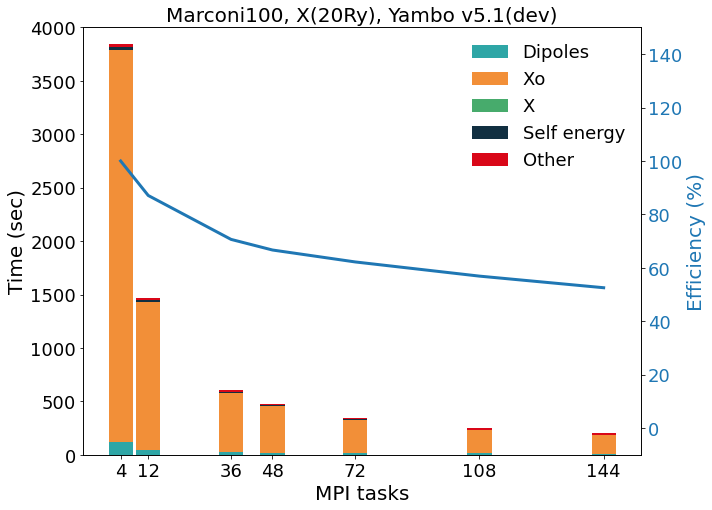

In [25]:
#[(scaling['mpi']=!16) | (scaling['mpi']!=64)]
build_scaling_plot(scaling=scaling[(scaling['mpi']!=16) & (scaling['mpi']!=64) & (scaling['mpi']!=180)], 
                   pile=pile, colors=colors, bar_width=7, efficiency=True,
                   legend_loc='upper right', title=r'Marconi100, X(20Ry), Yambo v5.1(dev)', 
                   file_name='scaling_1nodes.png', y_lim=[0,4000])

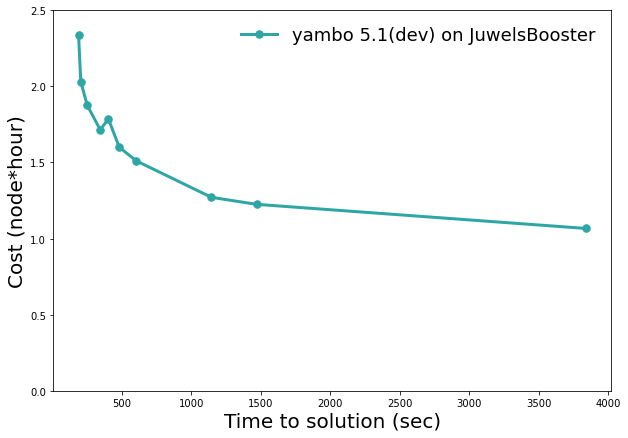

In [14]:
build_cost_plot(scaling=scaling, label='yambo 5.1(dev) on JuwelsBooster', y_lim=[0,2.5])

In [15]:
def build_speedup_plot(scaling, label='yambo', title=None, y_lim=None, x_axis='mpi', file_name='speedup.png'):
    fig, ax = plt.subplots(figsize=(10, 7))
    if x_axis=='mpi':
        xlabel = 'MPI tasks'
    elif x_axis=='nodes':
        xlabel = 'Nodes'
    else:
        xlabel = x_axis
    ax.set_xlabel(xlabel,fontsize=20)
    ax.set_ylabel('Speedup',fontsize=20)
    ax.plot(scaling[x_axis], scaling['ideal'], 
             linewidth=3, color='black', marker='.', markersize=15,
             label='ideal')
    ax.plot(scaling[x_axis], scaling['speedup'], 
             linewidth=3, color=colors[0], marker='.', markersize=15,
             label=label)
    if y_lim: ax.set_ylim(y_lim)
    ax.legend()
    ax.legend(fontsize='18',framealpha=0.0)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
    plt.xticks(scaling[x_axis])
    if title: plt.title(title, fontsize=20)
    plt.savefig(file_name, bbox_inches='tight')

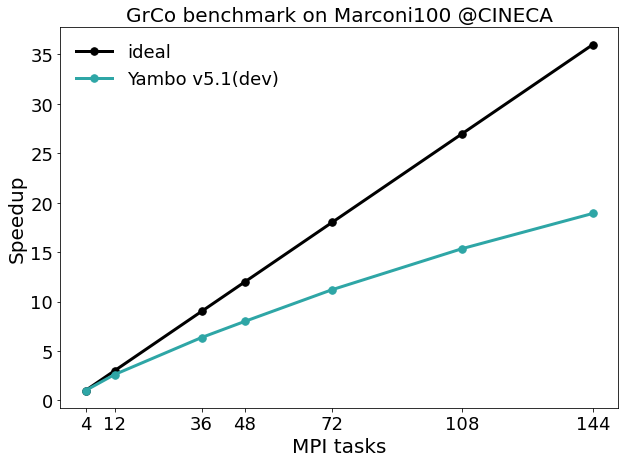

In [26]:
s=True;n=False
#                 1  3  4  9  12 16 18 27 36 45 
filtro=pd.Series((s, s, n, s, s, n, s, s, s, n), index=scaling.mpi.index)
build_speedup_plot(scaling=scaling[filtro], title=r'GrCo benchmark on Marconi100 @CINECA', label=r'Yambo v5.1(dev)', x_axis='mpi')

In [9]:
condition = (scaling['nodes']!=1) & (scaling['nodes']!=4) & (scaling['nodes']!=12) & (scaling['nodes']!=16)
scaling[condition][['mpi', 'nodes', 'Time-Profile'] + pile].to_csv('strong_scaling.csv', sep='\t', index=False)

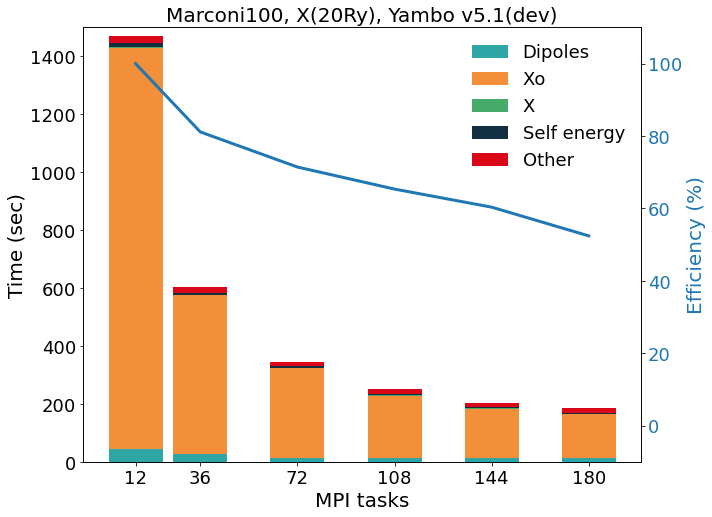

In [15]:
build_scaling_plot(scaling=scaling[condition], 
                   pile=pile, colors=colors, bar_width=20, efficiency=True,
                   legend_loc='upper right', title=r'Marconi100, X(20Ry), Yambo v5.1(dev)', 
                   file_name='scaling_3nodes.png', y_lim=[0,1500])